# Trading Strategies

Let's start with a classic and simple trading strategy: the moving average crossover. The idea behind this strategy is to buy a stock when its fast simple moving average (SMA) crosses above its slow SMA and to short it when the fast SMA crosses below the slow SMA.

Let's start with our imports in the cell below, and preparing our data frame in the cell below that.

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

plt.style.use("ggplot")

This time we'll try to fetch our data directly from yfinance.

In [68]:
# Try with yfinance
df = yf.download("JPM", "2020-01-01", "2023-06-30")
df

# If not, use this URL
# df = pd.read_csv("https://raw.githubusercontent.com/ImperialCollegeLondon/efds-ta-python/refs/heads/main/data/JPM_data.csv")


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,JPM,JPM,JPM,JPM,JPM
Date,,,,,
2020-01-02,120.733574,120.742139,119.167604,119.621135,10803700
2020-01-03,119.140305,119.906784,118.055180,118.416888,10386800
2020-01-06,119.045578,119.080034,117.555682,117.607353,10259000
2020-01-07,117.021751,118.726951,116.970081,118.227446,10531300
2020-01-08,117.934608,118.485785,116.780585,116.866699,9695300
...,...,...,...,...,...
2023-06-23,132.198929,132.513109,131.027837,131.903766,9907500
2023-06-26,132.522644,133.303358,131.094496,132.217965,8429700


## Compute and Plot SMAs

Before we can implement our strategy, we need to calculate the fast (short-term) and slow (long-term) SMAs. For this example, we'll use 60-day and 80-day SMAs.

In [69]:
FAST = 20
SLOW = 100

df["FastMA"] = df.Close.rolling(window=FAST).mean()
df["SlowMA"] = df.Close.rolling(window=SLOW).mean()

df

# only run it once

Price,Close,High,Low,Open,Volume,FastMA,SlowMA
Ticker,JPM,JPM,JPM,JPM,JPM,,
Date,,,,,,,
2020-01-02,120.733574,120.742139,119.167604,119.621135,10803700,NaN,NaN
2020-01-03,119.140305,119.906784,118.055180,118.416888,10386800,NaN,NaN
2020-01-06,119.045578,119.080034,117.555682,117.607353,10259000,NaN,NaN
2020-01-07,117.021751,118.726951,116.970081,118.227446,10531300,NaN,NaN
2020-01-08,117.934608,118.485785,116.780585,116.866699,9695300,NaN,NaN
...,...,...,...,...,...,...,...
2023-06-23,132.198929,132.513109,131.027837,131.903766,9907500,133.238120,129.908087
2023-06-26,132.522644,133.303358,131.094496,132.217965,8429700,133.405691,129.911132



Remember we'll have a window-length of NaNs in our data frame. This is because we don't have enough data points to calculate an N-day moving average until the Nth day. 
Let's plot the closing price with the SMAs to visually inspect the crossover points.

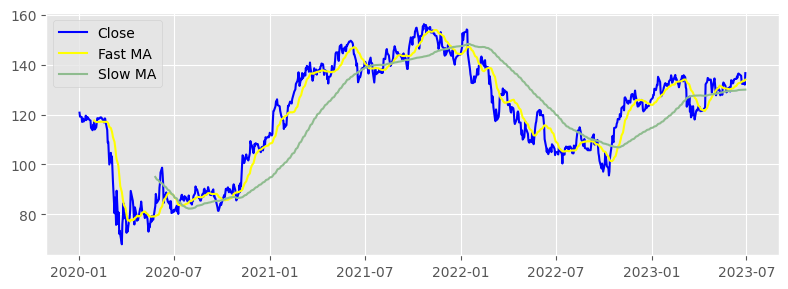

In [70]:
plt.figure(figsize = (8,3))
plt.plot(df.Close, label="Close", color="blue")
plt.plot(df.FastMA, label="Fast MA", color="yellow")
plt.plot(df.SlowMA, label="Slow MA", color="darkseagreen")

plt.legend()
plt.tight_layout()

## Signals

To apply our strategy to the data, we will create a `Signal` column which will contain 1 for buy signals (when the fast SMA is above the slow SMA) and -1 for sell signals. Because we are in a *wait* position while we *wait* for the slow SMA to kick-in, we'll fill the Signal column with 0 for those rows. We'll use `where()` for both of these.

In [71]:
df["Signal"] = 0

df.Signal = np.where(df.FastMA > df.SlowMA, 1, df.Signal)

df.Signal = np.where(df.FastMA < df.SlowMA, -1, df.Signal)

df.Signal.value_counts()

Signal
 1    458
-1    322
 0     99
Name: count, dtype: int64

### Exercise: Blink and you'll miss it

Can you identify on which dates we had a crossover?

In [72]:
df["Prev_Signal"] = df["Signal"].shift(1)
condition = abs(df.Signal - df.Prev_Signal) == 2

df[condition]

# OR df[abs(df.Signal.diff()) == 2]


Price,Close,High,Low,Open,Volume,FastMA,SlowMA,Signal,Prev_Signal
Ticker,JPM,JPM,JPM,JPM,JPM,,,,
Date,,,,,,,,,
2020-06-29,80.925156,82.221697,80.211622,81.273222,18499700,87.905173,87.884283,1,-1.0
2020-07-02,81.415016,83.435890,80.773604,83.242587,27845600,86.654006,86.775743,-1,1.0
2020-07-17,86.247513,87.934504,86.229936,87.864211,16137700,83.661234,83.547972,1,-1.0
2020-10-05,87.828224,88.014450,86.489161,87.189730,13871900,85.715910,85.918731,-1,1.0
2020-10-20,89.007675,90.249184,88.785976,88.954463,11257100,86.955567,86.883485,1,-1.0
2021-07-08,136.392395,137.829147,135.579129,136.997819,17834600,138.643530,139.211706,-1,1.0
2021-08-23,141.597244,141.949655,140.277967,140.359289,7934600,140.540907,140.533808,1,-1.0
2021-12-15,143.577759,145.314077,143.041414,145.314077,14014200,146.637650,146.890247,-1,1.0


## Backtesting

Backtesting is the process of testing a trading strategy on relevant historical data. We can calculate how it would have performed, had it been applied in the past. The simplest backtest calculates the returns that would have been realised if the strategy was implemented.

First, we create a new column with the signal from the previous day. When we backtest, we have to imagine we're trading in real time. Since our signals are based on close prices, we won't be able to act on them until the following day when the market re-opens. Failing to do this is called *look-ahead bias*.

In [73]:
df["Position"] = df.Signal.shift(1)



Next we calculate the market daily returns normally using `pct_change()`. We then calculate our strategy returns by multiplying our buy/sell position with the market returns. Here is how it works:

- On days when the market gains (+ market return)
    - In the buy position (+) , our strategy gains
    - In the sell position (-), our strategy loses
- On days when the market loses (- market return)
    - In the buy position (+), our strategy loses
    - In the sell position (-), our strategy gains

In [74]:
df["Returns"] = df.Close.pct_change()
df.Returns = np.where(df.SlowMA.isna(), 0, df.Returns)

df["Stratergy"] = df.Returns * df.Position

df

Price,Close,High,Low,Open,Volume,FastMA,SlowMA,Signal,Prev_Signal,Position,Returns,Stratergy
Ticker,JPM,JPM,JPM,JPM,JPM,,,,,,,
Date,,,,,,,,,,,,
2020-01-02,120.733574,120.742139,119.167604,119.621135,10803700,NaN,NaN,0,NaN,NaN,0.000000,NaN
2020-01-03,119.140305,119.906784,118.055180,118.416888,10386800,NaN,NaN,0,0.0,0.0,0.000000,0.000000
2020-01-06,119.045578,119.080034,117.555682,117.607353,10259000,NaN,NaN,0,0.0,0.0,0.000000,0.000000
2020-01-07,117.021751,118.726951,116.970081,118.227446,10531300,NaN,NaN,0,0.0,0.0,0.000000,0.000000
2020-01-08,117.934608,118.485785,116.780585,116.866699,9695300,NaN,NaN,0,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-23,132.198929,132.513109,131.027837,131.903766,9907500,133.238120,129.908087,1,1.0,1.0,-0.005230,-0.005230
2023-06-26,132.522644,133.303358,131.094496,132.217965,8429700,133.405691,129.911132,1,1.0,1.0,0.002449,0.002449


To determine if our strategy would profit or lose, we can calculate the cumulative returns of our strategy for the period. We can then compare it to a *buy & hold* strategy (where we buy at the start of the period and sell at the end), which is represented as the cumulative market returns.

In [75]:
df["MarketReturn"] = (1 + df.Returns).cumprod() - 1
df["StratergyReturn"] = (1+ df.Stratergy).cumprod() -1
df.tail()

Price,Close,High,Low,Open,Volume,FastMA,SlowMA,Signal,Prev_Signal,Position,Returns,Stratergy,MarketReturn,StratergyReturn
Ticker,JPM,JPM,JPM,JPM,JPM,,,,,,,,,
Date,,,,,,,,,,,,,,
2023-06-23,132.198929,132.513109,131.027837,131.903766,9907500,133.238120,129.908087,1,1.0,1.0,-0.005230,-0.005230,0.698047,0.389900
2023-06-26,132.522644,133.303358,131.094496,132.217965,8429700,133.405691,129.911132,1,1.0,1.0,0.002449,0.002449,0.702205,0.393304
2023-06-27,132.532135,133.141478,131.903746,132.341718,8154000,133.513278,129.917768,1,1.0,1.0,0.000072,0.000072,0.702327,0.393404
2023-06-28,131.951324,132.541635,131.351512,132.494028,7558600,133.567070,129.924736,1,1.0,1.0,-0.004382,-0.004382,0.694867,0.387297
2023-06-29,136.559494,136.683271,133.150994,133.360457,15423200,133.934578,129.957476,1,1.0,1.0,0.034923,0.034923,0.754057,0.435746


Let's plot these for a visual representation.

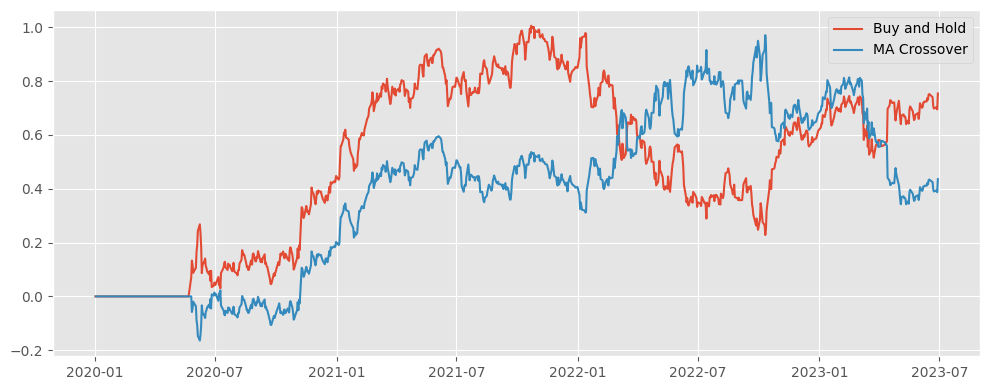

In [77]:
plt.figure(figsize=(10,4))
plt.plot(df.MarketReturn, label="Buy and Hold")
plt.plot(df.StratergyReturn, label="MA Crossover")
plt.legend()
plt.tight_layout()



### Exercise: BB Breakout

Implement an Bollinger Bands Breakout strategy and backtest it on JPM.

- First create high and low Bollinger Bands as usual
- Then generate signals as follows:
  - Buy (+1) when the close price crosses above the upper band
    - Hold the position until a signal change
  - Sell (-1) when the close price crosses under the lower band
    - Hold the position until a signal change
- Generate positions
- Calculate the strategy returns and cumulative strategy returns
- Report and plot the cumulative strategy and market returns

**HINT** You can create an empty column by assigning it `np.nan` and propagate a value forwards with `ffill()`.